In [1]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [5]:
import sys 
from deepscore import deepscore
from deepscore import marker_analysis

2023-03-30 16:27:53.681849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('15', '10'), color_map='gist_earth')

In [7]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',

'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#000000'}

In [8]:
adata = sc.read('objects/merged_1stQC.h5ad')

In [9]:
ref_py = sc.read('../../../external_references/local.h5ad')
ref_py.var['ENSG'] = ref_py.var.index.copy()
ref_py.var.index = ref_py.var['feature_name'].copy()
ref_py.layers['counts'] = ref_py.raw.X.todense().copy()

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.normalize_total(ref_py, target_sum=1e4)
sc.pp.log1p(ref_py)


ref_py, adata = marker_analysis.find_common_genes(ref_py, adata, target_n_genes=2000)


adata.var['shared_HVG'] = adata.var.index.isin(adata.var.index)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


n_feat = ref_py.shape[1]
n_labs = len(ref_py.obs['author_cell_type'].cat.categories)
ds = deepscore.DeepScore(hidden_nodes=[128, 64], n_features=n_feat, 
               n_labels=n_labs, batch_size=32, dropout_rate=0.3, 
               epochs=10, weight_reg=True)

ds.set_reference(ref_py, label_by='author_cell_type', test_prop=0.2)


Dimensions before filtering: (19985, 33234) and (75318, 35103)

Looking for 5000 HVG
Found 1212 genes in common
Looking for 6000 HVG
Found 1619 genes in common
Looking for 7000 HVG
Found 2056 genes in common
Filtering the data to these features and scaling



Dimensions after filtering: (19985, 2056) and (75318, 2056)
Model: "deepscore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 2056)             8224      
 ormalization)                                                   
                                                                 
 dense128 (Dense)            (None, 128)               263296    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense64 (Dense)             (None, 64)                8256      
                                                              

2023-03-30 16:28:26.272530: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 131485312 exceeds 10% of free system memory.


In [ ]:

ds.train(earlystopping=True, patience=10, lr_scheduler=scheduler)
ds.model.save(f'models/deepscore')


adata = ds.annotate(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

Epoch 1/10


2023-03-30 16:28:26.409259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 118335136 exceeds 10% of free system memory.


450/450 [==============================] - 4s 3ms/step - loss: 0.5367 - categorical_accuracy: 0.8519 - val_loss: 0.1736 - val_categorical_accuracy: 0.9350 - lr: 0.0010
Epoch 2/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1971 - categorical_accuracy: 0.9404 - val_loss: 0.1630 - val_categorical_accuracy: 0.9412 - lr: 0.0010
Epoch 3/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1278 - categorical_accuracy: 0.9597 - val_loss: 0.1769 - val_categorical_accuracy: 0.9468 - lr: 0.0010
Epoch 4/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1159 - categorical_accuracy: 0.9635 - val_loss: 0.2086 - val_categorical_accuracy: 0.9375 - lr: 0.0010
Epoch 5/10
450/450 [==============================] - 1s 3ms/step - loss: 0.0852 - categorical_accuracy: 0.9724 - val_loss: 0.2094 - val_categorical_accuracy: 0.9425 - lr: 0.0010
Epoch 6/10
450/450 [==============================] - 1s 3ms/step - loss: 0.0751 - categorical_accuracy: 0.9767 - va

2023-03-30 16:28:43.593678: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 619415232 exceeds 10% of free system memory.
2023-03-30 16:28:43.958910: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 619415232 exceeds 10% of free system memory.
2023-03-30 16:28:44.227903: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 619415232 exceeds 10% of free system memory.


2354/2354 [==============================] - 2s 859us/step


In [12]:
adata.write('objects/Deepscore.h5ad', compression = 'gzip')

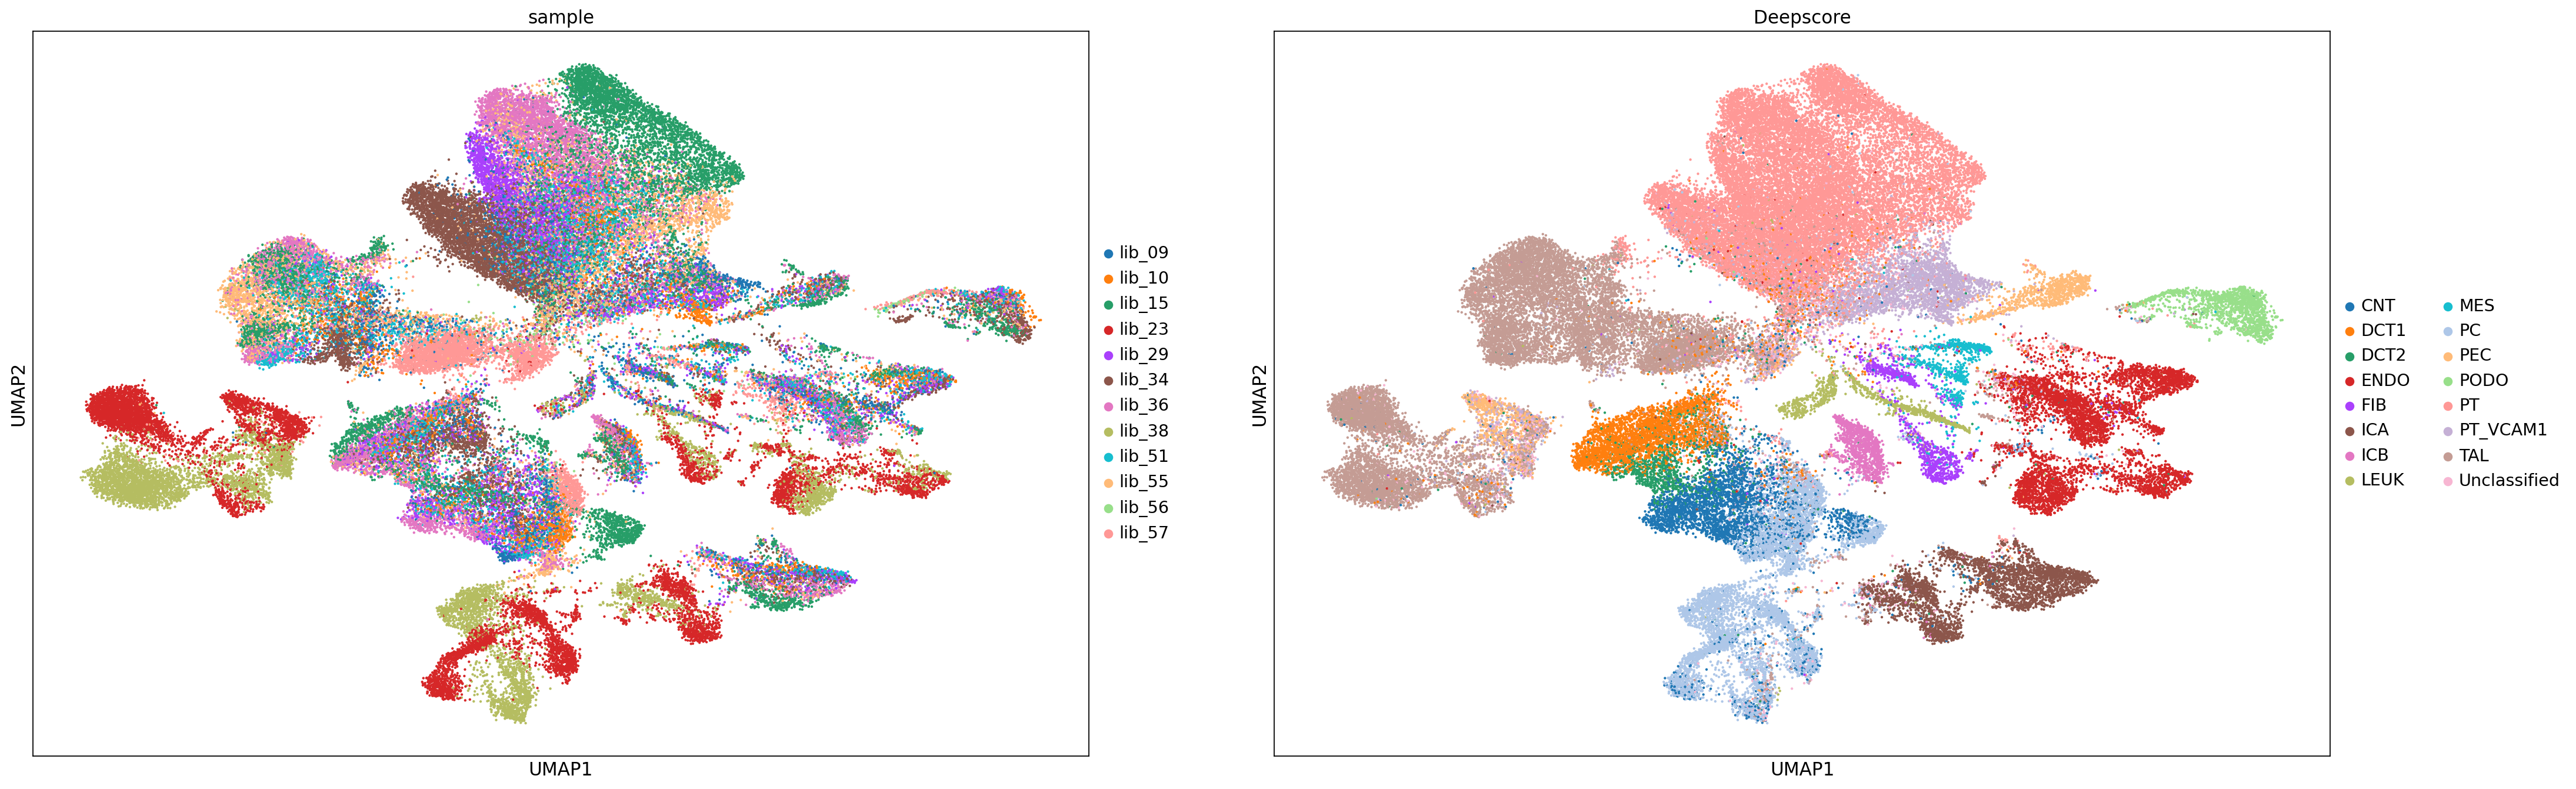

In [14]:
sc.pl.umap(adata, color = ['sample','Deepscore'], size = 15)